In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
%cd /content/drive/MyDrive/Wiremid_Test
ds = pd.read_csv('dataset.csv')
df = ds.copy()

print(f"The dataset has {df.shape[0]} istances and {df.shape[1]} features.")
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Wiremid_Test
The dataset has 7420 istances and 16 features.


,DocumentRatingSource,FlownYear,FlownMonth,AgentCode,AgentName,POS,POSCountryName,OriginCode,DestinationCode,CargoType,ProductCode,SpecialHandlingCodeList,CommodityCode,ChargeableWeight,Pieces,Revenue
0,XXXX,2017,NOVEMBER,SPRTQLS,SPRT4FP23CI1H34U12IFDORKMSBKLSW,QQJ,FBDFZRQ7ONHZOUWG0XX3VAORZJQEAYOPBCLJ,FTS,ZZZ,YYY,X,RWCBA,RC,21.0,1,15.050
1,XXXX,2017,SEPTEMBER,SPRTQLS,SPRT4FP23CI1H34U12IFDORKMSBKLSW,QQJ,FBDFZRQ7ONHZOUWG0XX3VAORZJQEAYOPBCLJ,FTS,ZZZ,YYY,X,RWCBA,ZW,13.2,1,9.460
2,XXXX,2017,SEPTEMBER,PJMIGRN,PJMIGWSX3CI1SROQTOOFWTJYDDMKEH,JLL,LVSSPJMDKYSQRCHI,JLL,ZZZ,YYY,X,RWCBA,ZW,15.6,1,9.160
3,XXXX,2017,OCTOBER,SPRTQLS,SPRT4FP23CI1H34U12IFDORKMSBKLSW,QQJ,FBDFZRQ7ONHZOUWG0XX3VAORZJQEAYOPBCLJ,FTS,ZZZ,YYY,X,RWCBA,ZW,3.0,1,2.150
4,XXXX,2017,SEPTEMBER,PBKDDPW,PBKDWYFR3DRTS3ZLNHTSGTJYDDMKEH,JUW,JJDIVESWZJQEAYOPBCLJ,JUW,ZZZ,YYY,X,RWCBA,BW,12.0,1,17.080
5,XXXX,2017,OCTOBER,PBKDDPW,PBKDWYFR3DRTS3ZLNHTSGTJYDDMKEH,JUW,JJDIVESWZJQEAYOPBCLJ,JUW,ZZZ,YYY,X,RWCBA,BW,4.2,1,5.980
6,XXXX,2017,SEPTEMBER,PBKDDPW,PBKDWYFR3DRTS3ZLNHTSGTJYDDMKEH,JUW,JJDIVESWZJQEAYOPBCLJ,JUW,ZZZ,YYY,X,RWCBA,RU,7.2,1,10.250
7,XXXX,2017,SEPTEMBER,VBTDDVB,VBTDW0QNSHVLXPOOMDT,JNV,PJMIV5OVXKAFPJMDKYSQRCHI,JNV,ZZZ,YYY,Y,RWCBA,B2324,30.3,1,274.021
8,XXXX,2017,SEPTEMBER,PBKDDPW,PBKDWYFR3DRTS3ZLNHTSGTJYDDMKEH,JUW,JJDIVESWZJQEAYOPBCLJ,JUW,ZZZ,YYY,X,RWCBA,BW,0.3,1,0.430
9,XXXX,2017,NOVEMBER,PBKDDPW,PBKDWYFR3DRTS3ZLNHTSGTJYDDMKEH,JUW,JJDIVESWZJQEAYOPBCLJ,JUW,ZZZ,YYY,X,RWCBA,RU,9.9,1,14.090


### Missing values
A first check is performed to assess whether or not there are missing values.

In [ ]:
# Check if there are missing values
print('Percentage of data without missing values: ', df.dropna().shape[0]/ float(df.shape[0]))

Percentage of data without missing values:  1.0


### Data Cleaning
(By hypothesis it has been performed already)  
In case the percentage was less than $1.0$, the next step would have been to compute the percentage of missing values per each feature, and drop the corresponding column if the computed value exceeds a threshold, e.g. 0.65. This feature-wise check would be performed as follows:
```python
for column in df.columns:
    missing_percentage = (df[column].isnull().sum() / len(df)) * 100
    print(f'Percentage of missing values for {column}: {missing_percentage:.2f}%')
```
On the remaining columns,*Imputation* is chosen over *Complete Case Analysis*. Indeed, the dataset at hand should resemble a real-life one hence, no row is supposed to be filtered out in order not to trigger bias.   
Imputation involves replacing missing values with statistical estimates i.e. mean, median, or mode. Statistics would be retrieved over the training set and then applied to the test set. This approach is suitable for small and randomly missing data. Else, each feature with missing values would be modeled as a function of other features via *Iterative Imputer*.

### Feature Selection  
This step is motivated by the Occam's Razor principle, which states that *model explainability* decreases when the input data has a lot of features, hence making it difficult to interpret the model.   

A preliminary step is to remove redundant/unuseful features, since these can introduce noise while making it harder to discern patterns:  
* $POS$ attribute is filtered out since it is encompassed also by the $POSCountryName$ feature
* $AgentName$ attribute is filtered out since, by assumption, each agent can be uniquely identified by $AgentCode$ attribute

In [ ]:
# Drop unuseful features
df = df.drop('POS', axis=1)
df = df.drop('AgentName', axis=1)

A further step is to drop columns that assume constant values. Indeed, these don't provide any information or variability in the data neither contribute to the interpretability of the model, hence they do not contribute to the predictive power of a model.

In [ ]:
# Drop constant columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
df.drop(columns=constant_columns, inplace=True)

### Duplicate data
Removing duplicates helps improve data quality by eliminating *inconsistencies* and getting round *biased model training*. Indeed, the model could end up assigning more importance to certain patterns that are duplicated, potentially affecting its generalization performance on unseen data.  
As a matter of fact, duplicate rows can *skew* statistical analyses and lead to incorrect conclusions.

In [ ]:
# Remove duplicate rows
df = df.drop_duplicates()
print(f"The dataset now has {df.shape[0]} rows istances.")

The dataset now has 6637 rows istances.


After removing duplicate rows, the number of instances i.e. data points is still way bigger than the one of the features, making the model less prone to the Curse of Dimensionality.

### Data distribution
Skewness and Kurtosis are employed to draw insights into the shape and distribution of a dataset, hence information about its outliers.  
* Skewness  
It can indicate the presence of outliers in a distribution. Positive skewness (long tail to the right) suggests that the data may have outliers on the right side, and negative skewness (long tail to the left) suggests potential outliers on the left side.  
* Kurtosis  
It measures the tailness of a distribution. High kurtosis indicates heavier tails, which means that there may be more extreme values or outliers in the dataset.

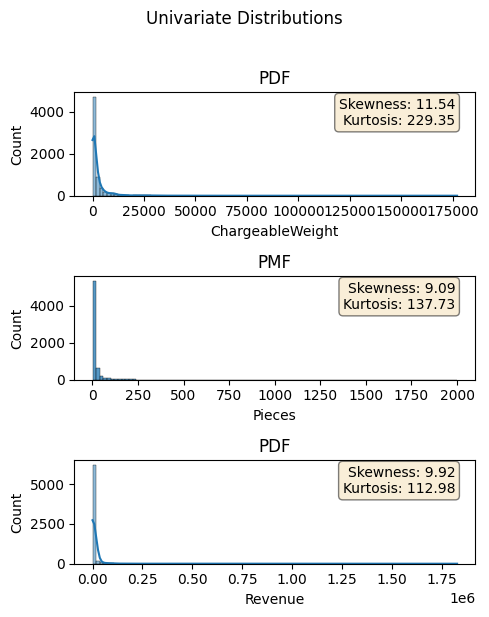

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

numeric_data = list(df.select_dtypes(include=['float64', 'int64']).columns)
fig, axes = plt.subplots(nrows=len(numeric_data), ncols=1, figsize=(5, 2 * len(numeric_data)))
fig.suptitle('Univariate Distributions', y=1.02)

def plot_univariate_distribution(axes, feature):
    if df[feature].dtype == np.float64:
        sns.histplot(df[feature], kde=True, bins=100, ax=axes)
        axes.set_title('PDF')
    elif df[feature].dtype == np.int64:
        sns.histplot(df[feature], bins=100, discrete=False, ax=axes)
        axes.set_title('PMF')

    skewness = skew(df[feature])
    kurt = kurtosis(df[feature])

    axes.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', transform=axes.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

for i, feature in enumerate(numeric_data):
    plot_univariate_distribution(axes[i], feature)

plt.tight_layout()
plt.show()

### Data Transformation
Machine learning algorithms like Linear Regression assume that the variables are *normally distributed*. If a variable is not normally distributed, sometimes it is possible to find a mathematical transformation, as Logarithmic and Square Root transformations, so that the transformed variable is Gaussian. Gaussian distributed variables many times boost the machine learning algorithm performance.

In [ ]:
def transform_feature(feature, skewness):
    transformed_feature = df[feature].copy()

    # Handle case of negative skewness i.e. turn it into positive skew
    if skewness < 0:
        # Find a constant 'k' such that the smallest (k - x) is at least 1
        k = df[feature].min() + 1
        transformed_feature = k - transformed_feature

    # High skew case
    if abs(skewness) > 1:
        transformed_feature = np.log1p(transformed_feature)
    # Moderate skew case
    elif (abs(skewness) > -1 and abs(skewness) < 0.5) or (abs(skewness) > 0.5 and abs(skewness) < 1):
        transformed_feature = np.sqrt(transformed_feature)

    return transformed_feature

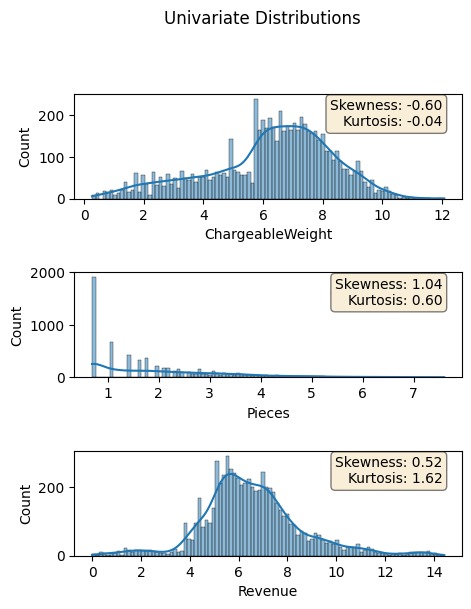

In [ ]:
def plot_univariate_distribution(axes, feature):
    if df[feature].dtype == np.float64:
        sns.histplot(df[feature], kde=True, bins=100, ax=axes)
    elif df[feature].dtype == np.int64:
        sns.histplot(df[feature], bins=100, discrete=False, ax=axes)

    skewness = skew(df[feature])
    kurt = kurtosis(df[feature])

    axes.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', transform=axes.transAxes, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


fig, axes = plt.subplots(nrows=len(numeric_data), ncols=1, figsize=(5, 2 * len(numeric_data)))
fig.suptitle('Univariate Distributions', y=1.02)



for i, feature in enumerate(numeric_data):
    skewness = skew(df[feature])

    tr_fe = transform_feature(feature, skewness)
    df[feature] = tr_fe
    plot_univariate_distribution(axes[i], feature)

plt.subplots_adjust(hspace=0.7)
plt.show()

The next step would have been to assess statistical significance of patterns

1.   List item
2.   List item

between *numerical features* and a *continuous target* variable.  
* Continuous Features  
Linear Regression is used to assess relevance of these features. Its statistical summary includes the p-value which, when is high, implies that the feature may not be statistically significant in explaining variability in the target.
In the task at hand there is only one continuous feature, hence this check for feature comprehension cannot be applied.

* Categorical Features  
ANOVA (Analysis of Variance) helps identify features that significantly contribute to the observed variance by analyzing variations in means across different levels of the target.  
This technique though relies on the following assumptions:
    * Samples are independent
    * Each sample is from a normally distributed population (that is why this step is performed after the skewness has been handled)
    * Population standard deviations of the groups are all equal  

Hence, in the task at hand it cannot be assessed due to '$Pieces$', even though in the dataset there are nominal attributes that will be later turned into numerical data via Encoding.

### Encoding of nominal attributes  
Encoding categorical variables is essential for machine learning models like XGBoost, linear regression, and Gaussian processes, as these algorithms require numerical input features. Transformation ensures that the models can effectively interpret and learn from categorical information, allowing for accurate predictions and meaningful insights in the presence of qualitative data.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Check if there are categorical features that need to be turned into numerical values later
categoricalFeatures = []

for i in df.select_dtypes(include=["object"]):
    categoricalFeatures.append(i)

# Label Encoding
# It has been performed for categorical variables whose total number of unique instancesis unknown
for col in categoricalFeatures:
    if col not in ['FlownMonth']:
        df[col] = pd.factorize(df[col])[0]

# One-Hot Encoding
# Months are 12 in total, hence one-hot encoding would not lead to the "curse of dimensionality"
df = pd.get_dummies(df, columns=['FlownMonth'])

Now we have all the features in numerical format.  
Visualizing the covariance matrix of data provides valuable insights into the relationships and dependencies between different variables. Indeed, it aids in understanding how variables jointly contribute to the overall variance in the dataset.

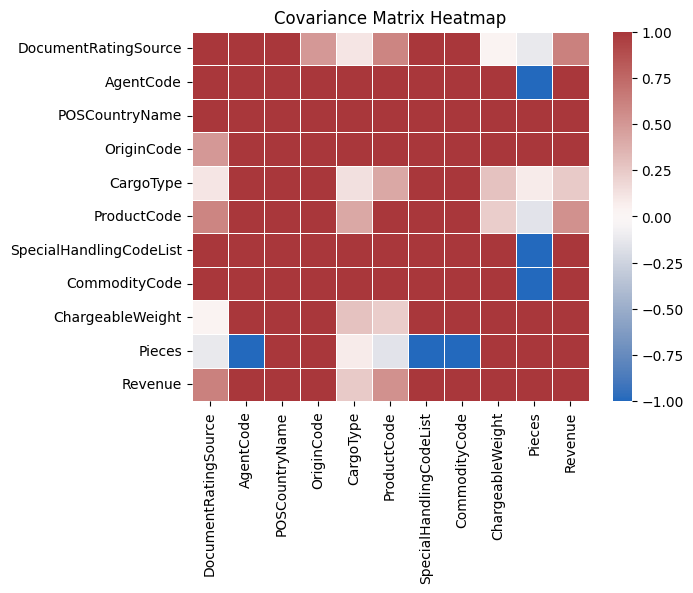

In [ ]:
# Extract the numerical columns for covariance matrix
numeric_data = df[df.select_dtypes(include=['float64', 'int64']).columns]
# Calculate the covariance matrix
cov_matrix = numeric_data.cov()
# Plot the heatmap
sns.heatmap(cov_matrix, annot=False, cmap='vlag', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Covariance Matrix Heatmap')
plt.show()

The decision to retain *all* features is driven by the recognition of high correlations within the covariance matrix, indicating potential redundancy in the information carried by these features.  
Moreover, the identification of negative covariances highlights inverse relationships between variables.

### Feature Standardization
Feature standardization is especially pertinent in Gaussian Processes and Linear Regression, where the algorithms rely on the scale of input features. Performing feature standardization within each fold of a k-fold cross-validation ensures that the standardization parameters, such as mean and variance, are computed solely on the training data for that specific fold. Applying these parameters to both the training and test data within the same fold maintains the integrity of the validation process by preventing data leakage and ensuring that the model is evaluated on a fair and consistent basis.  
This approach enhances the reliability of performance metrics and facilitates a more robust assessment of the model's generalization capabilities across various folds.

In [ ]:
def normalize(X_train, X_test, y_train, y_test):
    X_train_mean, X_train_var = X_train.mean(0), X_train.std(0) + 1e-9
    y_train_mean, y_train_var = y_train.mean(0), y_train.std(0) + 1e-9

    X_train = (X_train - X_train_mean)/X_train_var
    X_test = (X_test - X_train_mean)/X_train_var

    y_train = (y_train - y_train_mean)/y_train_var
    y_test = (y_test - y_train_mean)/y_train_var

    return X_train, X_test, y_train, y_test, y_train_var

### Models
* Linear Regression [baseline]  
It provides a straightforward linear relationship between input features and the target variable, serving as a benchmark against which more complex models can be evaluated.  

* XGBoost  
It is an ensemble learning technique, is chosen for its ability to capture non-linear relationships and handle complex interactions among features. The following hyperparameters have been fine-tuned:
    * learning rate: controls the step size during the optimization process
    * subsample: determines the fraction of training data used in each boosting round
    * max depth: restricts the maximum depth of each tree
This tuning is aimed at enhancing the predictive accuracy and generalization capabilities of the XGBoost model in comparison to a default or poorly tuned configuration.

### Metrics
Mean Squared Error and Mean Absolute Error are both suitable for regression tasks because they provide quantitative measures of how well a regression model is performing in terms of predicting numerical values.
* MSE  
It is commonly used when there is a desire to heavily penalize larger errors, making it suitable for situations where outliers or extreme errors should be minimized. The squared term in MSE amplifies the impact of larger deviations from the predicted values, making it sensitive to outliers.  

* MAE  
On the other hand, MAE is preferred when a more straightforward and linear measure of error is needed. MAE treats all errors equally, providing a more intuitive average of the absolute errors without the amplification effect seen in MSE.
* Rationale behind using both    

Using both MSE and MAE can be complementary in understanding different aspects of the regression model's performance. While MSE emphasizes larger errors and is sensitive to outliers, MAE offers a broader view by considering the average magnitude of errors without the squared amplification. Together, these metrics can provide a more comprehensive evaluation of the model's predictive accuracy, helping to identify areas of improvement and better understanding the overall performance across various error scenarios.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb


# Features
X = df.drop(columns=['Revenue']).to_numpy().astype(np.float64)
# Target
y = df['Revenue'].values
# Number of folds for cross-validation
k_folds = 5

# Initialize KFold cross-validator
kf = KFold(n_splits=k_folds)

# Lists to store the mean squared errors for each fold
mse_scores_lr = []
mse_scores_xgb = []
# Lists to store the mean absolute errors for each fold
mae_scores_lr = []
mae_scores_xgb = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the features using the scaler fit on the training data
    X_train, X_test, y_train, y_test, y_train_var = normalize(X_train, X_test, y_train, y_test)

    # Linear Regression
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)

    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    mse_scores_lr.append(mse_lr)
    mae_scores_lr.append(mae_lr)

    # XGBoost with hyperparameter tuning
    param_grid_xgb = {
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.5, 0.7],
        'max_depth': [3, 6]
    }

    model_xgb = xgb.XGBRegressor()
    grid_search_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=3, scoring='neg_mean_squared_error')
    grid_search_xgb.fit(X_train, y_train)

    best_model_xgb = grid_search_xgb.best_estimator_

    y_pred_xgb = best_model_xgb.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    mse_scores_xgb.append(mse_xgb)
    mae_scores_xgb.append(mae_xgb)

    print(f'XGBoost Parameters: {grid_search_xgb.best_params_}')
    print(f'XGBoost Mean Squared Error: {- grid_search_xgb.best_score_}')

# Calculate and print the mean of the MSE scores
mean_mse_lr = np.mean(mse_scores_lr)
mean_mae_lr = np.mean(mae_scores_lr)
mean_mse_xgb = np.mean(mse_scores_xgb)
mean_mae_xgb = np.mean(mae_scores_xgb)

print(f'Mean Squared Error (Linear Regression): {mean_mse_lr}')
print(f'Mean Absolute Error (Linear Regression): {mean_mae_lr}')
print(f'Mean Squared Error (XGBoost): {mean_mse_xgb}')
print(f'Mean Absolute Error (XGBoost): {mean_mae_xgb}')


XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.5}
XGBoost Mean Squared Error: 0.1537267963159027
XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
XGBoost Mean Squared Error: 0.28967069536357554
XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.5}
XGBoost Mean Squared Error: 0.25823095357744
XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.5}
XGBoost Mean Squared Error: 0.24854827012192518
XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.7}
XGBoost Mean Squared Error: 0.3034651516987776
Mean Squared Error (Linear Regression): 0.6548051086659092
Mean Absolute Error (Linear Regression): 0.564069399501118
Mean Squared Error (XGBoost): 0.2369640689228652
Mean Absolute Error (XGBoost): 0.2299695727988933


### Sparse Variational Gaussian Process  
Gaussian Processes, while robust, encounter scalability issues due to the *cubic complexity* of inverting the covariance matrix concerning the number of data points.  
Sparse Variational Gaussian Process (SVGP) tackles this challenge by introducing "inducing points," a carefully selected subset of the dataset that serves to approximate the entire GP. This strategic reduction in computational burden allows SVGP to efficiently handle large-scale datasets. Key technical aspects include the utilization of inducing points as representatives of the data, capturing essential information while significantly reducing computational complexity. Furthermore, SVGP leverages a variational inference framework for model optimization, replacing the computation of the posterior distribution over latent functions in exact GPs with a more tractable variational distribution. Notably, for the specific regression task at hand, the absence of variational inference in SVGP underscores its adaptability to the task's requirements, showcasing its versatility without unnecessary computational overhead.

In [ ]:
!pip3 install gpflow
import gpflow
import tensorflow as tf
from gpflow.ci_utils import reduce_in_tests
from scipy.cluster.vq import kmeans2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.8/379.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 11.9 MB/s eta 0:00:00


In [ ]:
def run_adam(model, iterations, train_dataset, minibatch_size):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [ ]:
# K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True)
mse_folds = []
mae_folds = []
k = 0
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    # Standardize the features using the scaler fit on the training data
    X_train, X_test, Y_train, Y_test, Y_train_var = normalize(X_train, X_test, Y_train, Y_test)


    # Setup model
    M = 100  # Number of inducing locations
    N = X_train.shape[0]
    kernel = gpflow.kernels.SquaredExponential()
    Z = kmeans2(X_train, M, minit='points')[0]
    m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
    # Run minibatch Adam
    minibatch_size = 100
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train.reshape(-1,1))).repeat().shuffle(N)
    maxiter = reduce_in_tests(20000)
    logf = run_adam(m, maxiter, train_dataset, minibatch_size)
    # Predictions
    Y_pred_mean, Y_pred_var = m.predict_y(X_test)
    Y_pred_mean, Y_pred_var = Y_pred_mean.numpy(), Y_pred_var.numpy()
    mse_fold =  mean_squared_error(Y_test, Y_pred_mean)
    mse_folds.append(mse_fold)
    mae_fold =  mean_absolute_error(Y_test, Y_pred_mean)
    mae_folds.append(mae_fold)
    print('[fold: %d] - MSE: %.3f - MAE: %.3f'%(k,mse_fold,mae_fold))
    k += 1

[fold: 0] - MSE: 0.216 - MAE: 0.288
[fold: 1] - MSE: 0.199 - MAE: 0.287
[fold: 2] - MSE: 0.216 - MAE: 0.297
[fold: 3] - MSE: 0.203 - MAE: 0.289
[fold: 4] - MSE: 0.229 - MAE: 0.292
